# Dataset energético

O objetivo de cada grupo de trabalho passa por desenvolver o melhor modelo possível capaz de prever a quantidade de energia, em kWh, produzida por painéis solares e injectada, em redes elétricas existentes, a cada hora do dia.

O dataset utilizado nesta competição contém um conjunto de features sendo de destacar a feature Injeção na rede (kWh) . Esta feature indica, numa escala qualitativa (None, Low, Medium, High e Very_High), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal (i.e., numa determinada hora de um determinado dia). Se o valor desta feature for None, significa que não foi injectada nenhuma energia na rede (ou porque nada foi obtido dos painéis solares, ou porque toda a energia produzida pelos painéis foi consumida localmente). Um valor de Very_High implica a existência de uma quantidade muito alta de energia injectada na rede eléctrica naquele ponto temporal.

Para treino e tuning dos modelos de Machine Learning ser-vos-ão disponibilizados dois datasets com dados energéticos e dois datasets com dados meteorológicos. Tantos os datasets energéticos como os meteorológicos estão divididos por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Os grupos de trabalho poderão adicionar aos datasets qualquer atributo que achem relevante.

Para obtenção de scores na competição, os grupos de trabalho deverão prever, para cada registo do dataset de teste ("energia_202301-202304.csv"), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal, utilizando a escala None, Low, Medium, High e Very_High.

## The Data

### Treino

- energia_202109-202112.csv
- energia_202201-202212.csv
- meteo_202109-202112.csv
- meteo_202201-202212.csv

### Teste

- energia_202301-202304.csv
- meteo_202301-202304.csv

## Import Libraries

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the data

In [114]:
energia_2021 = pd.read_csv('daasbstp2023/energia_202109-202112.csv', encoding='latin-1')
energia_2022 = pd.read_csv('daasbstp2023/energia_202201-202212.csv', encoding='latin-1')
meteo_2021 = pd.read_csv('daasbstp2023/meteo_202109-202112.csv', encoding='latin-1')
meteo_2022 = pd.read_csv('daasbstp2023/meteo_202201-202212.csv', encoding='latin-1')

In [115]:
print(energia_2021.columns)
print(meteo_2021.columns)

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')


In [116]:
print('Energia 2021')
print(energia_2021.info())
print('\n')
print('Energia 2022')
print(energia_2022.info())
print('\n\n')
print('Meteo 2021')
print(meteo_2021.info())
print('Meteo 2022')
print(meteo_2022.info())

Energia 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
 5   Injeção na rede (kWh)    566 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
None


Energia 2022
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     8760 non-null   object 
 1   Hora                     8760 non-null   int64  
 2   Normal (kWh)             8760 non-null

In [117]:
print('Energia 2021')
energia_2021.head()

Energia 2021


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,NaN
1,2021-09-29,1,0.0,0.0,0.0,NaN
2,2021-09-29,2,0.0,0.0,0.0,NaN
3,2021-09-29,3,0.0,0.0,0.0,NaN
4,2021-09-29,4,0.0,0.0,0.0,NaN


In [118]:
print('Energia 2022')
energia_2022.head()

Energia 2022


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,0.0,0.486,0.0,NaN
1,2022-01-01,1,0.0,0.429,0.0,NaN
2,2022-01-01,2,0.0,0.463,0.0,NaN
3,2022-01-01,3,0.0,0.545,0.0,NaN
4,2022-01-01,4,0.0,0.439,0.0,NaN


In [119]:
print('Meteo 2021')
meteo_2021.head()

Meteo 2021


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [120]:
print('Meteo 2022')
meteo_2022.info()

Meteo 2022
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   8760 non-null   int64  
 1   dt_iso               8760 non-null   object 
 2   city_name            8760 non-null   object 
 3   temp                 8760 non-null   float64
 4   feels_like           8760 non-null   float64
 5   temp_min             8760 non-null   float64
 6   temp_max             8760 non-null   float64
 7   pressure             8760 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             8760 non-null   int64  
 11  wind_speed           8760 non-null   float64
 12  rain_1h              1898 non-null   float64
 13  clouds_all           8760 non-null   int64  
 14  weather_description  8760 non-null   object 
dtypes: float64(8), int64(4), ob

## Join the Data

Criar novas colunas Data e Hora, nos datasets meteo_2021 e meteo_2022, com a informação da coluna dt_iso

Ex:
- dt_iso = 2021-09-01 00:00:00 +0000 UTC
    - Data = 2021-09-01
    - Hour = 00


In [121]:
meteo_2021['Data'] = meteo_2021['dt_iso'].str[:10]
meteo_2021['Hora'] = meteo_2021['dt_iso'].str[11:13].astype(int)
meteo_2022['Data'] = meteo_2022['dt_iso'].str[:10]
meteo_2022['Hora'] = meteo_2022['dt_iso'].str[11:13].astype(int)

In [122]:
print('Meteo 2021')
meteo_2021.info()

Meteo 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   2928 non-null   int64  
 1   dt_iso               2928 non-null   object 
 2   city_name            2928 non-null   object 
 3   temp                 2928 non-null   float64
 4   feels_like           2928 non-null   float64
 5   temp_min             2928 non-null   float64
 6   temp_max             2928 non-null   float64
 7   pressure             2928 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             2928 non-null   int64  
 11  wind_speed           2928 non-null   float64
 12  rain_1h              537 non-null    float64
 13  clouds_all           2928 non-null   int64  
 14  weather_description  2928 non-null   object 
 15  Data                 2928 n

In [123]:
print('Meteo 2022')
meteo_2022.head()

Meteo 2022


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Data,Hora
0,1640995200,2022-01-01 00:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds,2022-01-01,0
1,1640998800,2022-01-01 01:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds,2022-01-01,1
2,1641002400,2022-01-01 02:00:00 +0000 UTC,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds,2022-01-01,2
3,1641006000,2022-01-01 03:00:00 +0000 UTC,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds,2022-01-01,3
4,1641009600,2022-01-01 04:00:00 +0000 UTC,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds,2022-01-01,4


Juntar os datasets tendo em conta os fields data e a hora.

In [124]:
# Merge the DataFrames based on "Data" and "Hora" columns
energia_meteo_2021 = pd.merge(energia_2021, meteo_2021, on=["Data", "Hora"])
energia_meteo_2022 = pd.merge(energia_2022, meteo_2022, on=["Data", "Hora"])

# Concatenate the merged DataFrames
energia_meteo = pd.concat([energia_meteo_2021, energia_meteo_2022])

# Save the merged data to a new CSV file
energia_meteo.to_csv("daasbstp2023/merged_data.csv", index=False)

# No enunciado avisa que None é quando não há infos, ao junta-los, os None viram NaN
energia_meteo['Injeção na rede (kWh)'].fillna('None', inplace=True)

In [125]:
energia_meteo.columns

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)', 'dt', 'dt_iso',
       'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h',
       'clouds_all', 'weather_description'],
      dtype='object')

In [126]:
energia_meteo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11016 entries, 0 to 8759
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
 6   dt                       11016 non-null  int64  
 7   dt_iso                   11016 non-null  object 
 8   city_name                11016 non-null  object 
 9   temp                     11016 non-null  float64
 10  feels_like               11016 non-null  float64
 11  temp_min                 11016 non-null  float64
 12  temp_max                 11016 non-null  float64
 13  pressure                 11016 non-null  int64  
 14  sea_level                0 n

In [127]:
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds


## Handling missing data and possible data transformations
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

### 1. Missing Values

Data                           0
Hora                           0
Normal (kWh)                   0
Horário Económico (kWh)        0
Autoconsumo (kWh)              0
Injeção na rede (kWh)          0
dt                             0
dt_iso                         0
city_name                      0
temp                           0
feels_like                     0
temp_min                       0
temp_max                       0
pressure                       0
sea_level                  11016
grnd_level                 11016
humidity                       0
wind_speed                     0
rain_1h                     8732
clouds_all                     0
weather_description            0
dtype: int64

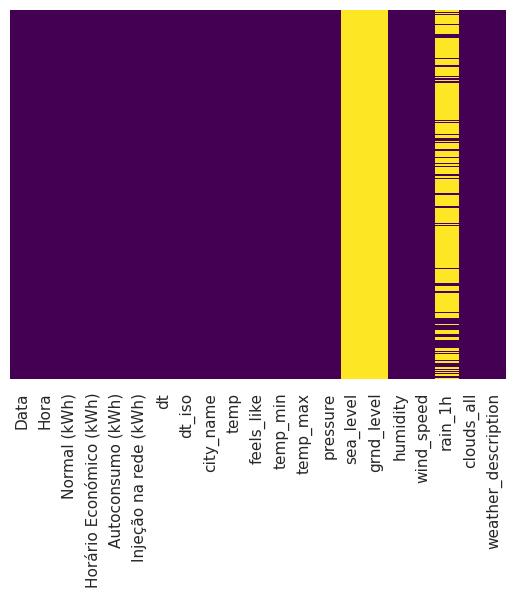

In [128]:
sns.heatmap(energia_meteo.isnull(),yticklabels=False,cbar=False,cmap='viridis')
energia_meteo.isnull().sum()

#### - Drop or fill

Começamos por eliminar as colunas que contém todos os vals a null - sea_level e grnd_level já que não contêm nenhuma informação

In [129]:
energia_meteo.drop(['sea_level','grnd_level'],axis=1,inplace=True)
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds


Agora vamos analizar a feature rain_1h

In [130]:
energia_meteo['rain_1h'].describe()

count    2284.000000
mean        0.896642
std         1.079381
min         0.100000
25%         0.210000
50%         0.460000
75%         1.092500
max         7.450000
Name: rain_1h, dtype: float64

Teoria: os NaN provavelmente provêem de horas sem chuva, logo, podemos substituir por 0

Então vamos testar colocar os vals nulls de rain_1h a zero

In [131]:
energia_meteo_n1 = energia_meteo.copy()

In [132]:
energia_meteo.fillna(0,inplace=True)

In [133]:
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds


Data                       0
Hora                       0
Normal (kWh)               0
Horário Económico (kWh)    0
Autoconsumo (kWh)          0
Injeção na rede (kWh)      0
dt                         0
dt_iso                     0
city_name                  0
temp                       0
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
humidity                   0
wind_speed                 0
rain_1h                    0
clouds_all                 0
weather_description        0
dtype: int64

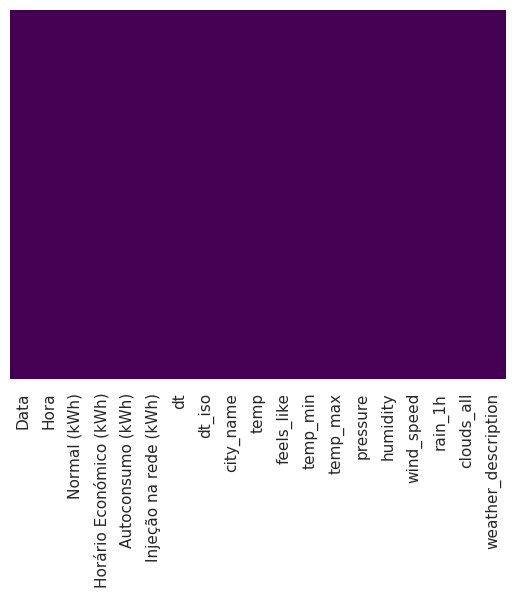

In [134]:
sns.heatmap(energia_meteo.isnull(),yticklabels=False,cbar=False,cmap='viridis')
energia_meteo.isnull().sum()

## Handling Categorical Features

Injeção na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


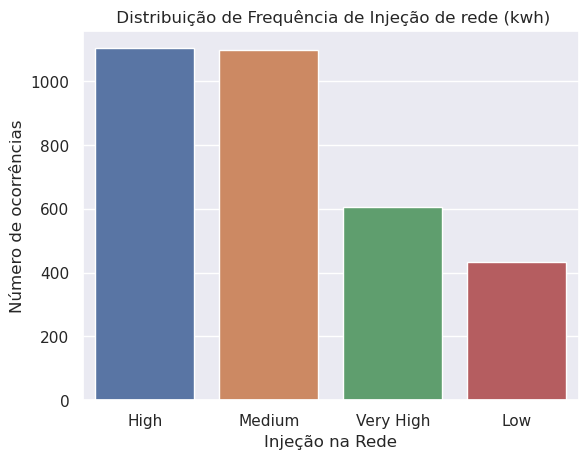

In [142]:
inj_rede_count = energia_meteo['Injeção na rede (kWh)'].value_counts()
print(inj_rede_count)
# remove None count
inj_rede_count = inj_rede_count.drop('None')
sns.set(style="darkgrid")
sns.barplot(x=inj_rede_count.index, y=inj_rede_count.values)
plt.title(' Distribuição de Frequência de Injeção de rede (kwh)')
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

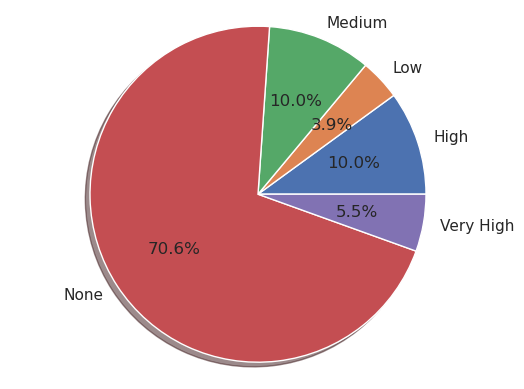

In [144]:
labels = energia_meteo['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
counts = energia_meteo['Injeção na rede (kWh)'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True)
ax1.axis('equal')
plt.show()